In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from gcn.dataloader import YooChooseDataset
from gcn.model import SAGEConv

In [3]:
from torch_geometric import utils, data
from matplotlib import pyplot as plt
import networkx as nx
import torch

In [4]:
ds = YooChooseDataset(root="/home/pranjal/GCN/pytorch-gcn/tmp/")

2020-08-29 22:00:16.552 | INFO     | gcn.dataloader:raw_file_names:32 - Required files check!


In [5]:
g_sample = utils.to_networkx(ds[1000])

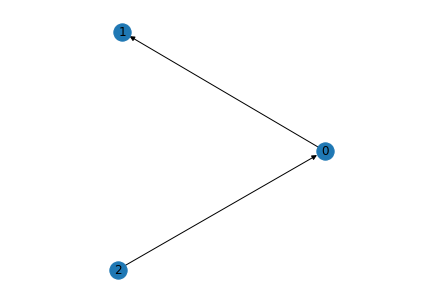

In [6]:
nx.draw_kamada_kawai(g_sample,with_labels=True)

In [7]:
list(g_sample.adjacency())

[(0, {1: {}}), (1, {}), (2, {2: {}, 0: {}})]

In [8]:
ds[1000].x

tensor([[11956],
        [19581],
        [19587]])

In [9]:
ds[1000].edge_index

tensor([[2, 2, 2, 0],
        [2, 2, 0, 1]])

In [10]:
# dl = data.DataLoader(ds)

In [11]:
# item_embedding = torch.nn.Embedding(num_embeddings=ds.num_embeddings, embedding_dim=128)
# conv1 = SAGEConv(ds.num_embeddings, 128)

In [12]:
# for tr in dl:
#     x, edge_index, batch = tr.x, tr.edge_index, tr.batch
#     x = item_embedding(x)
#     x = x.squeeze(1)
#     y = conv1(x, edge_index)
#     break

In [13]:
from torch_geometric.utils import add_self_loops, degree, add_remaining_self_loops, remove_self_loops

In [15]:
row, col = ds[1000].edge_index
deg = degree(col, ds[1000].x.size(0), dtype=ds[1000].x.dtype)
deg_inv_sqrt = deg.pow(-0.5)
norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

In [18]:
deg

tensor([1, 1, 2])

In [23]:
deg_inv_sqrt

tensor([1.0000, 1.0000, 0.7071])

In [32]:
# deg_inv_sqrt[row]
deg_inv_sqrt[col]

tensor([0.7071, 0.7071, 1.0000, 1.0000])